<a href="https://colab.research.google.com/github/nebuus/fun/blob/extra/Simple_NN_for_Gaussian_fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation  # this is needed for the animation API
import matplotlib.image as mpimg # for grayscale input image
from matplotlib.colors import Normalize   # this is needed to rescale the color during the simulation

In [39]:
def get_initial_configuration(N, random_influence=0.2):
    """
    Initialize a concentration configuration. N is the side length
    of the (N x N)-sized grid.
    `random_influence` describes how much noise is added.
    """

    # We start with a configuration where on every grid cell
    # there's a lot of chemical A, so the concentration is high
    A = (1-random_influence) * np.ones((N,N)) + random_influence * np.random.random((N,N))

    # Let's assume there's only a bit of B everywhere
    B = random_influence * np.random.random((N,N))

    return A, B

In [4]:
def draw(A,B):
    """draw the concentrations"""
    %matplotlib inline
    plt.clf()
    fig, ax = plt.subplots(1,2,figsize=(5.65,4))
    ax[0].imshow(A, cmap='Greys')
    ax[1].imshow(B, cmap='Greys')
    ax[0].set_title('A')
    ax[1].set_title('B')
    ax[0].axis('off')
    ax[1].axis('off')

    plt.show()

In [19]:
A, B = get_initial_configuration(200)

In [6]:
%matplotlib inline

In [16]:
def discrete_laplacian1(M):
    """Get the discrete Laplacian of matrix M"""
    L = -4*M
    L += np.roll(M, (0, 1), (0, 1))  # right neighbor
    L += np.roll(M, (0, -1), (0, 1))  # left neighbor
    L += np.roll(M, (-1, 0), (0, 1))  # top neighbor
    L += np.roll(M, (1, 0), (0, 1))  # bottom neighbor

    return L

def gray_scott_update1(A, B, DA, DB, f, k, delta_t):
    """
    Updates a concentration configuration according to a Gray-Scott model
    with diffusion coefficients DA and DB, as well as feed rate f and
    kill rate k.
    """
    #A, B = torch.tensor(A.detach().cpu().numpy()), torch.tensor(B.detach().cpu().numpy())

    # Let's get the discrete Laplacians first
    LA = discrete_laplacian1(A)
    LB = discrete_laplacian1(B)

    # Now apply the update formula
    diff_A = (DA*LA - A*B**2 + f*(1-A)) * delta_t
    diff_B = (DB*LB + A*B**2 - (k+f)*B) * delta_t

    A += diff_A
    B += diff_B

    return A, B

<Figure size 640x480 with 0 Axes>

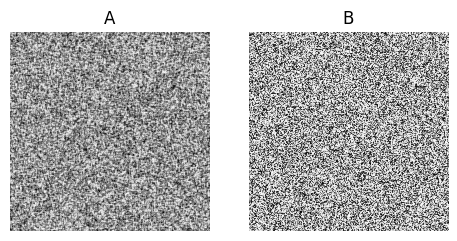

In [20]:
# update in time
delta_t = 1.0

# simulation steps
N_simulation_steps = 10

DA, DB, f, k = 0.14, 0.06, 0.040, 0.062 # bacteria
for t in range(N_simulation_steps):
    A_target, B_target = gray_scott_update1(A, B, DA, DB, f, k, delta_t)

draw(A_target,B_target)

In [21]:
def discrete_laplacian(M):
    """Get the discrete Laplacian of matrix M"""
    L = -4 * M
    L += torch.roll(M, (0, 1), (0, 1))  # right neighbor
    L += torch.roll(M, (0, -1), (0, 1))  # left neighbor
    L += torch.roll(M, (-1, 0), (0, 1))  # top neighbor
    L += torch.roll(M, (1, 0), (0, 1))  # bottom neighbor

    return L

def gray_scott_update(A, B, DA, DB, f, k, delta_t):
    """
    Updates a concentration configuration according to a Gray-Scott model
    with diffusion coefficients DA and DB, as well as feed rate f and
    kill rate k.
    """
    # Let's get the discrete Laplacians first
    LA = discrete_laplacian(A.detach())
    LB = discrete_laplacian(B.detach())

    # Now apply the update formula
    diff_A = (DA * LA - A * B**2 + f * (1 - A)) * delta_t
    diff_B = (DB * LB + A * B**2 - (k + f) * B) * delta_t

    A = A + diff_A
    B = B + diff_B

    return A, B, diff_A, diff_B

In [22]:
# Define a neural network to learn f and k
class GrayScottModel(nn.Module):
    def __init__(self):
        super(GrayScottModel, self).__init__()
        self.f = nn.Parameter(torch.tensor(0.035,requires_grad=True))
        self.k = nn.Parameter(torch.tensor(0.065, requires_grad=True))

    def forward(self, A, B, DA, DB, delta_t):
        f_clamped = torch.sigmoid(self.f)
        k_clamped = torch.sigmoid(self.k)
        A_pred, B_pred, _, _ = gray_scott_update(A, B, DA, DB, f_clamped, k_clamped, delta_t)
        return A_pred, B_pred

In [23]:
A_tensor = torch.tensor(A, dtype=torch.float32, requires_grad=True)
B_tensor = torch.tensor(B, dtype=torch.float32, requires_grad=True)

A_target_tensor = torch.tensor(A_target, dtype=torch.float32, requires_grad=True)
B_target_tensor = torch.tensor(B_target, dtype=torch.float32, requires_grad=True)

In [33]:
# Instantiate the model, set up optimizer, and define the loss function
model = GrayScottModel()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training loop
num_epochs = 3000
delta_t = 1.0
DA = 0.14
DB = 0.06

In [38]:
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Forward pass
    A_pred, B_pred = model(A_tensor, B_tensor, DA, DB, delta_t)

    # Compute loss
    loss_A = criterion(A_pred, A_target_tensor)
    loss_B = criterion(B_pred, B_target_tensor)

    # Backward pass and optimization
    loss_A.backward(retain_graph=True)
    loss_B.backward()
    optimizer.step()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

    f_clamped = torch.clamp(torch.sigmoid(model.f), 0, 1)
    k_clamped = torch.sigmoid(model.k)

    loss = loss_A + loss_B

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Get the optimized parameters
f_optimized, k_optimized = model.f.item(), model.k.item()
print(f'Optimized Parameters: f={f_clamped}, k={k_clamped}')

Epoch [100/3000], Loss: 0.0002
Epoch [200/3000], Loss: 0.0002
Epoch [300/3000], Loss: 0.0002
Epoch [400/3000], Loss: 0.0002
Epoch [500/3000], Loss: 0.0002
Epoch [600/3000], Loss: 0.0002
Epoch [700/3000], Loss: 0.0002
Epoch [800/3000], Loss: 0.0002
Epoch [900/3000], Loss: 0.0002
Epoch [1000/3000], Loss: 0.0002
Epoch [1100/3000], Loss: 0.0002
Epoch [1200/3000], Loss: 0.0002
Epoch [1300/3000], Loss: 0.0002
Epoch [1400/3000], Loss: 0.0002
Epoch [1500/3000], Loss: 0.0002
Epoch [1600/3000], Loss: 0.0002
Epoch [1700/3000], Loss: 0.0002
Epoch [1800/3000], Loss: 0.0002
Epoch [1900/3000], Loss: 0.0002
Epoch [2000/3000], Loss: 0.0002
Epoch [2100/3000], Loss: 0.0002
Epoch [2200/3000], Loss: 0.0002
Epoch [2300/3000], Loss: 0.0002
Epoch [2400/3000], Loss: 0.0002
Epoch [2500/3000], Loss: 0.0002
Epoch [2600/3000], Loss: 0.0002
Epoch [2700/3000], Loss: 0.0002
Epoch [2800/3000], Loss: 0.0002
Epoch [2900/3000], Loss: 0.0002
Epoch [3000/3000], Loss: 0.0002
Optimized Parameters: f=0.08044977486133575, k=0.

In [42]:
f_clamped

tensor(0.0804, grad_fn=<ClampBackward1>)

<Figure size 640x480 with 0 Axes>

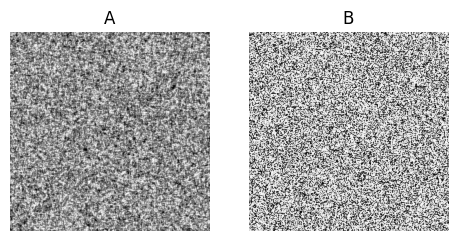

In [43]:
delta_t = 1.0

# simulation steps
N_simulation_steps = 1

DA, DB = 0.14, 0.06
f = 0.08044977486133575
k = 0.004793681204319
for t in range(N_simulation_steps):
    A_target, B_target = gray_scott_update1(A, B, DA, DB, f, k, delta_t)

draw(A_target,B_target)